In [1]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 74kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## The imports 
import numpy as np
from PIL import Image 
import cv2
from matplotlib import pyplot as plt
from scipy import linalg

In [4]:
#define Variables
IMAGE1_PATH = '/content/drive/MyDrive/Machine Vision/HW3/Homework3-Files/Q1-Left.jpg'
IMAGE2_PATH = '/content/drive/MyDrive/Machine Vision/HW3/Homework3-Files/Q1-Right.jpg'
Threshold1 = 0.1
THE_8_POINT_ALGORITHM = 8

In [5]:
# We need to read the images that are located in our files
Left_Image = cv2.imread(IMAGE1_PATH, 0) 
Right_Image = cv2.imread(IMAGE2_PATH, 0) 

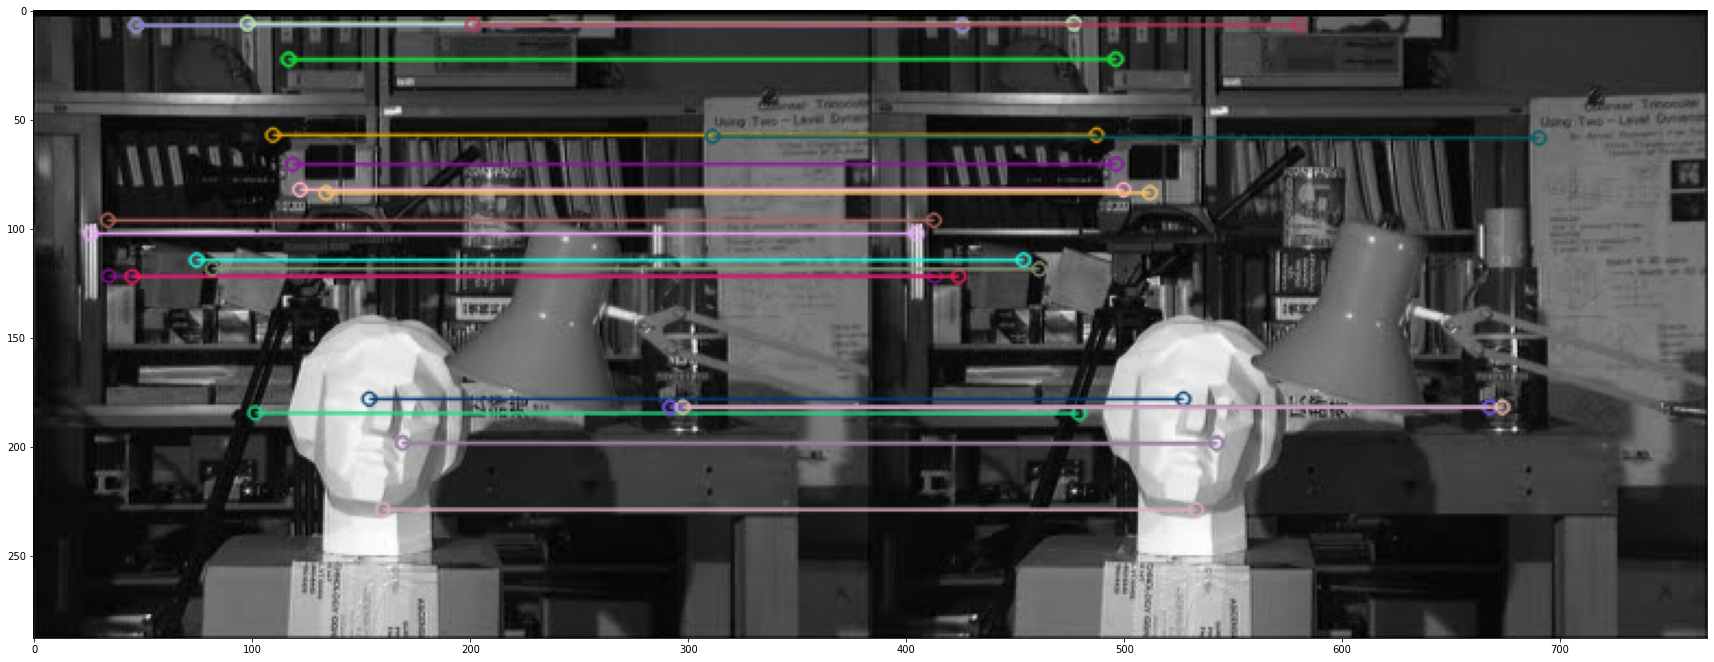

(<matplotlib.image.AxesImage at 0x7fab8c2c9cf8>, None)

In [6]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT

key_left, des_left = sift.detectAndCompute(Left_Image,None)
key_right, des_rieght = sift.detectAndCompute(Right_Image,None)

# BFMatcher with default params

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des_left,des_rieght,k=2)

# Apply ratio test
good = []
good_key_left = []
good_key_right = []
pts1 = []
pts2 = []
num = 0
for m,n in matches:
  if m.distance < Threshold1*n.distance:
    good_key_left.append([np.round(key_left[m.queryIdx].pt[0]),np.round(key_left[m.queryIdx].pt[1]), 1])
    good_key_right.append([np.round(key_right[m.trainIdx].pt[0]),np.round(key_right[m.trainIdx].pt[1]), 1])
    good.append([m])
    pts2.append(key_right[m.trainIdx].pt)
    pts1.append(key_left[m.queryIdx].pt)
    
    # print(num, pts2[num], key_right[m.trainIdx].pt, [np.round(key_right[m.trainIdx].pt[0]),np.round(key_right[m.trainIdx].pt[1]), 1])

    num += 1

pts1 = np.int32(np.round(pts1))
pts2 = np.int32(np.round(pts2))

# cv.drawMatchesKnn expects list of lists as matches.
plt.subplots(figsize = (30, 30))
img3 = cv2.drawMatchesKnn(Left_Image,key_left,Right_Image,key_right,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [7]:
def Gen_Norm(img): # This function will generate a matrix that will normalize the data we have
  mean_array = np.mean(img, axis = 0)
  Sx = np.sqrt(2) / np.std(img[:, 0])
  Sy = np.sqrt(2) / np.std(img[:, 1])
  T  = np.array([[Sx, 0,  -Sx*mean_array[0]],[0,  Sy, -Sy*mean_array[1]],[0,  0,  1]])
  img = np.matmul(img, T[:-1, :])[:, :-1]
  return img, T


def Cal_Fundamental_Matrix(Left_img, Right_img): # This function will calculate the fundamental matrix
  N = len(Left_img)
  A = np.zeros((N, 9))

  Left_img, T_left = Gen_Norm(Left_img)
  Right_img, T_right = Gen_Norm(Right_img)

  # we will calculate the A matrix
  for i in range(N):
    L = np.append(Left_img[i], 1)
    R = np.append(Right_img[i], 1)
    A[i, :] = np.kron(L, R)

  # by using the SVD algorithm we will get the U S V matrix
  U,S,V = linalg.svd(A)
  
  # need to reshape it
  F = V[-1].reshape(3,3)

  #Calculate the SVD again for the F matrix

  U,S,V = linalg.svd(F)

  S[2] = 0

  F = np.matmul(U,np.matmul(np.diag(S),V))

  F = F/F[2, 2]
  F = np.matmul(np.matmul(T_right.T, F), T_left)
  return F

def Find_Depth(F, pts1, pts2): #This part we are going to measure the depth of the image
  U,S,V = np.linalg.svd(F.T)   
  e = V[-1]
  e = e / e[-1]
  e2 = np.array([[0, -e[2], e[1]], [e[2], 0, -e[0]], [-e[1], e[0], 0]])
  P1 = np.concatenate((np.eye(3), np.zeros((3,1))), axis = 1) # This is the part where we calculate the P matrix
  P2 = np.concatenate((np.matmul(e2, F), e.reshape(-1, 1)), axis = 1)
  Depth = []
  for i in range(len(pts2)):
    temp = triangulation(pts1[i], pts2[i], P1, P2)
    Depth.append(temp[-1])
  return Depth

def num_inline(pts1, pts2, F, threshold): # This function will count the number of inlines 

  # We need to attach the 1 do the end of the vector
  pts1 = np.concatenate((pts1, np.ones((len(pts1), 1))), axis=1)
  pts2 = np.concatenate((pts2, np.ones((len(pts2), 1))), axis=1)
  
  inline = 0
  for i in range(pts1.shape[0]):
    L1 = np.matmul(F, pts1[i])
    L2 = np.matmul(F.T, pts2[i])   
    F_new = np.matmul(pts2[i].reshape(1, -1), L1)
    abs_L1 = np.power(L1[0], 2) + np.power(L1[1], 2)
    abs_L2 = np.power(L2[0], 2) + np.power(L2[1], 2)
    Error = F_new * ((1/abs_L1) + (1/abs_L2))
    if Error < threshold:
      inline += 1

  return inline

def drawlines(img1,img2,lines,pts1,pts2): # This function is for drawing the image with the circles
  r,c = img1.shape
  img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
  img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
  for r,pt1,pt2 in zip(lines,pts1,pts2):
    color = tuple(np.random.randint(0,255,3).tolist()) # This part we will color them with a random color
    x0,y0 = map(int, [0, -r[2]/r[1] ])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
    img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
    img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
  return img1,img2

def triangulation(pts1, pts2, P1, P2):
    M = np.array([pts1[1]*P1[2] - P1[1], P1[0] - pts1[0]*P1[2], pts2[1]*P2[2] - P2[1], P2[0] - pts2[0]*P2[2]])
    U,S,V = np.linalg.svd(M)
    return V[-1]


In [27]:
#https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
class Ransac: # We are going to make a class 
  def __init__(self, p, threshold, algorithm=THE_8_POINT_ALGORITHM):
    self.p = p
    self.threshold = threshold
    self.algorithm = algorithm
  def Run(self, pts1, pts2): # this function will use the ransac method to find the best fundamental matrix
    N = np.inf
    n = 0
    Best_inline = 0
    Best_Fundamental = 0
    while N > n: # The condition to move on
      idx = np.random.choice(pts1.shape[0], size=self.algorithm, replace=False)
      new_pts1 = pts1[idx]
      new_pts2 = pts2[idx] 
      
      Fundamental = Cal_Fundamental_Matrix(new_pts1, new_pts2)
      
      inline = num_inline(pts1, pts2, Fundamental, self.threshold)
      if inline == len(pts1): # if all of them are inline then we can go out
        return Fundamental, inline
      if inline > Best_inline:
        Best_Fundamental = Fundamental
        Best_inline = inline

      N = np.log(1-self.p) / np.log(1 - np.power((inline-1)/len(pts1),self.algorithm))
      n += 1
      
    return Best_Fundamental, Best_inline


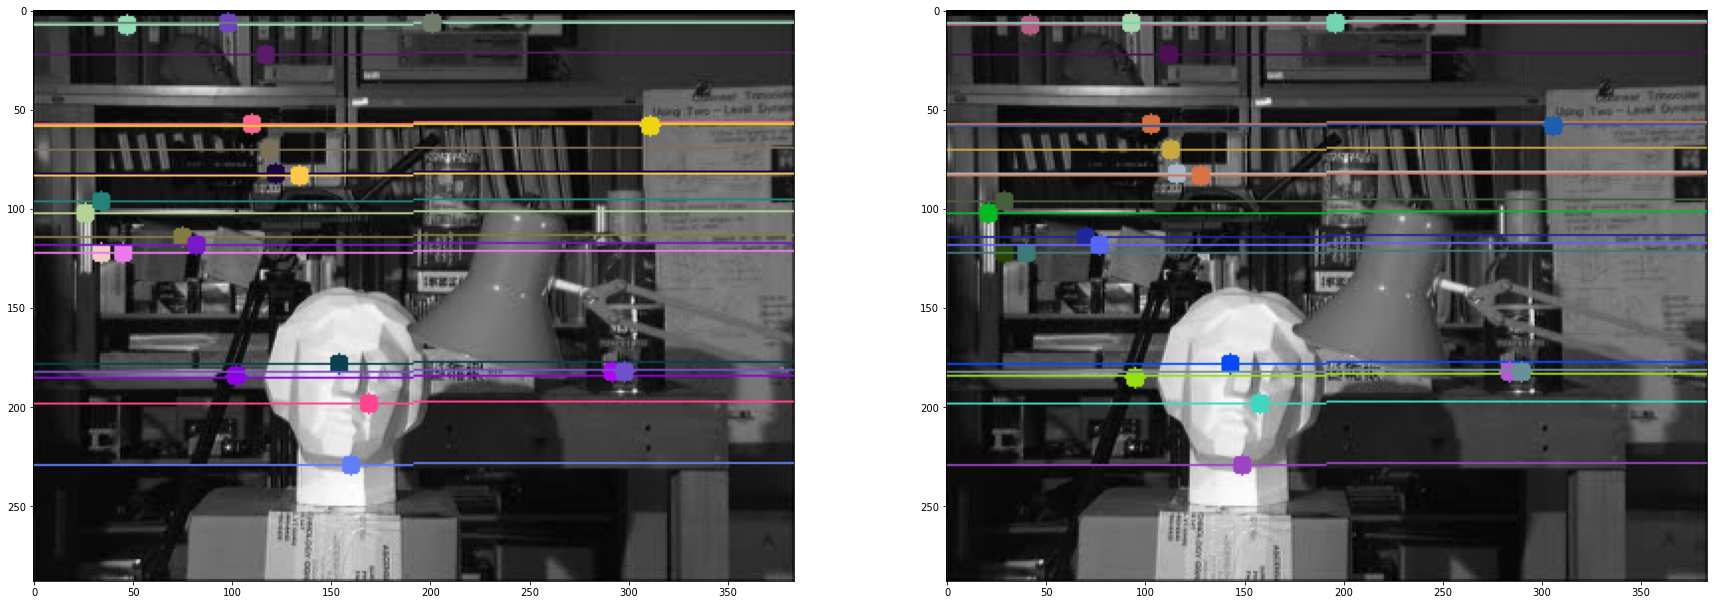

In [29]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
img1 = Left_Image
img2 = Right_Image
lines1 = np.transpose(np.matmul(F, np.transpose( np.concatenate((pts2, np.ones((len(pts2), 1))), axis=1))))
lines1 = np.divide(lines1, lines1[:, 1].reshape((len(pts2), 1)))
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = np.transpose(np.matmul(F, np.transpose( np.concatenate((pts1, np.ones((len(pts1), 1))), axis=1))))
lines2 = np.divide(lines2, lines2[:, 1].reshape((len(pts1), 1)))

img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplots(figsize = (30, 30))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [57]:
# This part we will make the class model with the treshold of p=0.99 and the thtrshold of sqrt(5.99)
My_Model = Ransac(0.99, np.sqrt(5.99))
F, inline = My_Model.Run(pts1, pts2)
print(F, inline)

[[-3.58726035e-19  4.00631055e-03 -6.60598463e-01]
 [-3.90467695e-03  8.06094720e-05  7.43197441e+13]
 [ 6.50494759e-01 -7.43197441e+13 -2.00000000e+00]] 26


In [58]:
# by using the fandamental matrix we want to find the depth
Depth = Find_Depth(F, pts1, pts2)
Depth = np.floor(255 - 255 * (Depth - min(Depth)) / (max(Depth) - min(Depth))) # The result needs to be normalized

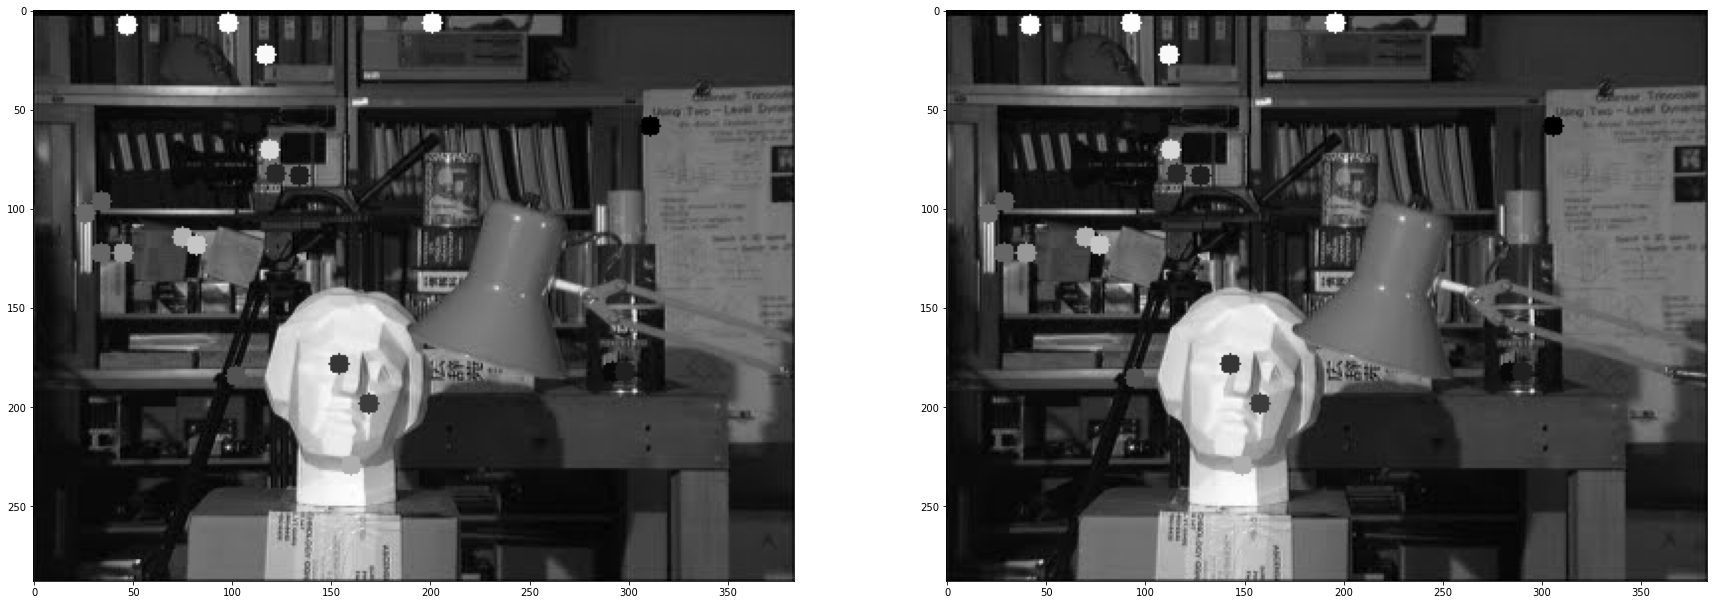

In [59]:
# This part we are going to the new image
img1 = Left_Image
img2 = Right_Image

r,c = img1.shape[0], img1.shape[1]
num = 0
# This part we will make the circles on the image and the light part is showing the depth
for pt1,pt2 in zip(pts1,pts2):
  color = Depth[num]
  img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
  img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
  num += 1

# we need to convert it will a particular RGB code
img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
plt.subplots(figsize = (30, 30))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()